<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_12/DNN_assignment_12_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:

import os
import random
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
import torch.optim as optim
from tqdm import tqdm
import time

#Dataset Processing

In [3]:
# Load dataset
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
val_ratio = 0.1
generator = torch.Generator().manual_seed(seed)
use_reduced_data = True

transform = transforms.Compose([
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-30, 30)),
    # transforms.ColorJitter(),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CIFAR10Dataset = torchvision.datasets.CIFAR10(root='.', download=True)
full_train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transformTest)

if use_reduced_data:
    total_reduced_size = 10000
    selected_indices = torch.randperm(len(full_train_dataset), generator=generator)[:total_reduced_size]
else:
    selected_indices = torch.arange(len(full_train_dataset))

val_size = int(len(selected_indices) * val_ratio)
train_size = len(selected_indices) - val_size
train_indices, val_indices = random_split(selected_indices, [train_size, val_size], generator=generator)


train_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transform),
    train_indices.indices
)

val_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transformTest),
    val_indices.indices
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

100%|██████████| 170M/170M [00:08<00:00, 19.3MB/s]


#Pretrained model

In [4]:

import torch.nn as nn
from torchvision.models import resnet50, mobilenet_v3_large

def get_resnet50(num_classes=10):
    model = resnet50(pretrained=True)

    # Adjust first conv and maxpool for CIFAR-10 input size
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last half: layer3, layer4, and fc
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True

    # Replace final classification layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_resNet18(num_classes=10):
    model = ResNet101(pretrained=True)

    # Adjust first conv stride for 32x32 input
    model.features[0][0].stride = (1, 1)

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last half of features (features[8:] since total 17 blocks) + classifier
    for i in range(8, len(model.features)):
        for param in model.features[i].parameters():
            param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True

    # Replace final classification layer
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

#training funtion

In [5]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, device, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    return model, history


In [6]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [7]:
model = get_resnet50()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model, history = train(model, train_loader, val_loader, device, epochs=30, lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


Epoch [1/30] Train Loss: 1.7639, Acc: 37.39% | Val Loss: 1.4596, Acc: 51.20%
Epoch [2/30] Train Loss: 1.4272, Acc: 48.43% | Val Loss: 1.1885, Acc: 58.60%
Epoch [3/30] Train Loss: 1.3038, Acc: 54.57% | Val Loss: 0.9815, Acc: 65.20%
Epoch [4/30] Train Loss: 1.1955, Acc: 58.24% | Val Loss: 1.0019, Acc: 65.20%
Epoch [5/30] Train Loss: 1.1085, Acc: 61.64% | Val Loss: 0.9570, Acc: 66.40%
Epoch [6/30] Train Loss: 1.0561, Acc: 63.54% | Val Loss: 0.9783, Acc: 67.20%
Epoch [7/30] Train Loss: 1.0145, Acc: 64.81% | Val Loss: 0.9197, Acc: 69.00%
Epoch [8/30] Train Loss: 0.9570, Acc: 66.16% | Val Loss: 0.7339, Acc: 74.70%
Epoch [9/30] Train Loss: 0.9394, Acc: 67.79% | Val Loss: 0.9686, Acc: 67.60%
Epoch [10/30] Train Loss: 0.8870, Acc: 69.01% | Val Loss: 0.7563, Acc: 74.50%
Epoch [11/30] Train Loss: 0.8543, Acc: 70.26% | Val Loss: 0.7332, Acc: 75.30%
Epoch [12/30] Train Loss: 0.8305, Acc: 70.96% | Val Loss: 0.7321, Acc: 74.60%
Epoch [13/30] Train Loss: 0.8076, Acc: 71.69% | Val Loss: 0.8047, Acc: 74

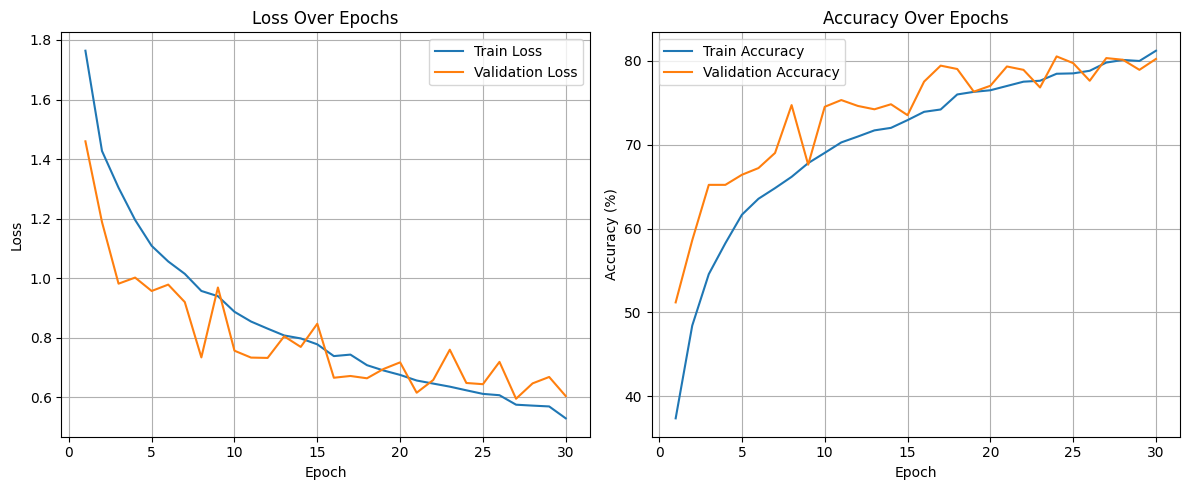

In [8]:
plot_training_history(history)

In [9]:
model = get_resNet18()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model, history = train(model, train_loader, val_loader, device, epochs=30, lr=0.001)

Epoch [1/30] Train Loss: 1.7902, Acc: 34.77% | Val Loss: 1.4363, Acc: 48.70%
Epoch [2/30] Train Loss: 1.4701, Acc: 46.60% | Val Loss: 1.2096, Acc: 56.80%
Epoch [3/30] Train Loss: 1.3338, Acc: 52.71% | Val Loss: 1.0628, Acc: 60.40%
Epoch [4/30] Train Loss: 1.2394, Acc: 56.09% | Val Loss: 1.0727, Acc: 63.70%
Epoch [5/30] Train Loss: 1.1571, Acc: 59.03% | Val Loss: 1.0664, Acc: 64.50%
Epoch [6/30] Train Loss: 1.0995, Acc: 61.78% | Val Loss: 0.9958, Acc: 66.00%
Epoch [7/30] Train Loss: 1.0465, Acc: 63.52% | Val Loss: 0.7936, Acc: 72.50%
Epoch [8/30] Train Loss: 0.9933, Acc: 65.26% | Val Loss: 0.8890, Acc: 69.40%
Epoch [9/30] Train Loss: 0.9628, Acc: 66.33% | Val Loss: 0.8317, Acc: 73.10%
Epoch [10/30] Train Loss: 0.9354, Acc: 67.13% | Val Loss: 0.8417, Acc: 70.80%
Epoch [11/30] Train Loss: 0.8852, Acc: 69.01% | Val Loss: 0.7500, Acc: 76.30%
Epoch [12/30] Train Loss: 0.8729, Acc: 69.38% | Val Loss: 0.7948, Acc: 75.90%
Epoch [13/30] Train Loss: 0.8469, Acc: 70.21% | Val Loss: 0.8020, Acc: 73

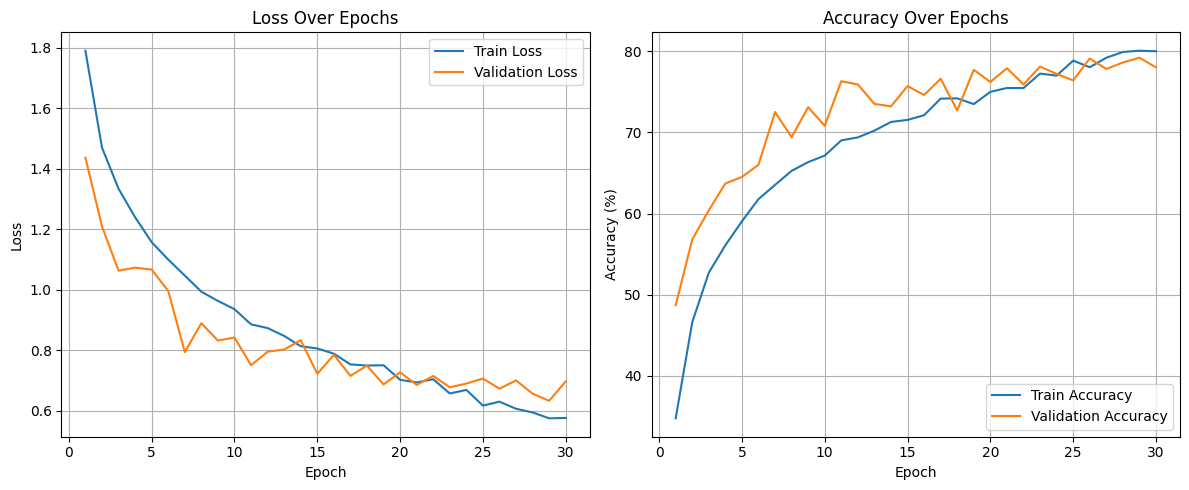

In [10]:
plot_training_history(history)